In [1]:
path = r"/Users/constantinslioussarenko/PythonGitRepositories/MyoMap"
sys.path.append(path+"/epgpy")
sys.path.append(path+"/machines")
sys.path.append(path+"/mutools")
sys.path.append(path+"/dicomstack")
sys.path.append(path+"/mrf-sim")

#import matplotlib
#matplotlib.use("TkAgg")
from mrfsim import T1MRF
from image_series import *
from utils_mrf import *
import json
from finufft import nufft1d1,nufft1d2
from scipy import signal,interpolate
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
from movements import *
from dictoptimizers import *
from toy_model_keras import *
import tensorflow as tf
%matplotlib inline
## Random map simulation


class PerformancePlotCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x = x_test
        self.y = y_test

    def on_train_batch_end(self, epoch, logs=None):
        #print('Evaluating Model...')
        x = self.x.reshape(1,-1)
        #print(x.shape)
        pred = self.model.predict(x)
        Y_pred=optimizer.paramDict["output_scaler"].inverse_transform(pred.reshape(1,-1))

        global predictions

        predictions.append(Y_pred[0])

        #print("=====Parameters comparison===========")
        # print("Index : {}".format(i))
        # print("wT1 : {} vs {}".format(Y_pred[0][0], self.y[0]))
        # print("fT1 : {} vs {}".format(Y_pred[0][1], self.y[1]))
        # print("attB1 : {} vs {}".format(Y_pred[0][2], self.y[2]))
        # print("df : {} vs {}".format(Y_pred[0][3], self.y[3]))
        # print("ff : {} vs {}".format(Y_pred[0][4], self.y[4]))

        #print('Model Evaluation: ', self.model.evaluate(self.x_test))

I was here


/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [2]:

useGPU=False

dictfile = "../mrf175.dict"
#dictfile = "mrf175_CS.dict"
dictfile = "../mrf175_SimReco2.dict"

with open("../mrf_sequence.json") as f:
    sequence_config = json.load(f)


seq = T1MRF(**sequence_config)

window = 8 #corresponds to nspoke by image
size=(256,256)

file_matlab_paramMap = "../data/Phantom1/paramMap.mat"

###### Building Map
#m = MapFromFile("TestPhantomV1",image_size=size,file=file_matlab_paramMap,rounding=True)

with open("../mrf_dictconf_SimReco2.json") as f:
    dict_config = json.load(f)

dict_config["ff"]=np.arange(0.,1.05,0.05)

window = 8 #corresponds to nspoke by image
region_size=16 #size of the regions with uniform values for params in pixel number (square regions)
size=(256,256)



file_matlab_paramMap = "../data/paramMap.mat"

###### Building Map
m = RandomMap("TestRandom",dict_config,image_size=size,region_size=region_size,mask_reduction_factor=1/4)

m.buildParamMap()

#m.plotParamMap(save=True)

##### Simulating Ref Images
m.build_ref_images(seq)

ntimesteps=175
nspoke=8
npoint = 2*m.images_series.shape[1]

radial_traj=Radial(total_nspokes=ntimesteps*nspoke,npoint=npoint)
kdata = m.generate_kdata(radial_traj,useGPU=useGPU)

volumes = simulate_radial_undersampled_images(kdata,radial_traj,m.image_size,density_adj=True,useGPU=useGPU)
mask = build_mask_single_image(kdata,radial_traj,m.image_size,useGPU=useGPU)#Not great - lets make both simulate_radial_.. and build_mask_single.. have kdata as input and call generate_kdata upstream


Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.
Building image series
Generating kdata


In [3]:
FF_list = list(np.arange(0., 1.05, 0.05))
keys, signal = read_mrf_dict(dictfile, FF_list)
Y_TF = np.array(keys)

signal=signal/np.expand_dims(np.linalg.norm(signal,axis=-1),axis=-1)
real_signal = signal.real
imag_signal = signal.imag

#real_signal=real_signal/np.expand_dims(np.linalg.norm(real_signal,axis=-1),axis=-1)
#imag_signal=imag_signal/np.expand_dims(np.linalg.norm(imag_signal,axis=-1),axis=-1)

X_TF = np.concatenate((real_signal, imag_signal), axis=1)
#X_TF = X_TF/np.expand_dims(np.linalg.norm(X_TF,axis=-1),axis=-1)


In [4]:
Y_TF[0]

array([5.5e+02, 3.0e+02, 3.0e-01, 6.0e-02, 0.0e+00])

(array([30780., 30780., 30780., 30780., 30780., 30780., 30780., 30780.,
        30780., 46170.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

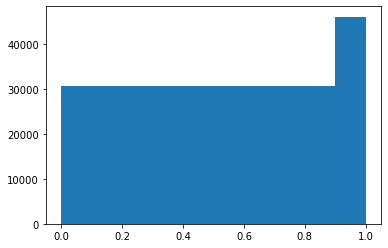

In [5]:
plt.hist(Y_TF[:,4])

In [6]:
df=pd.DataFrame(Y_TF)

In [7]:
df.describe()

,0,1,2,3,4
count,323190.000000,323190.0,323190.000000,3.231900e+05,323190.000000
mean,1127.631579,300.0,0.650000,-1.387822e-19,0.500000
std,353.100360,0.0,0.216025,3.872989e-02,0.302766
min,550.000000,300.0,0.300000,-6.000000e-02,0.000000
25%,830.000000,300.0,0.450000,-3.000000e-02,0.250000
50%,1115.000000,300.0,0.650000,-0.000000e+00,0.500000
75%,1400.000000,300.0,0.850000,3.000000e-02,0.750000
max,2000.000000,300.0,1.000000,6.000000e-02,1.000000


In [8]:

callbacks_list = []
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


i=np.random.choice(X_TF.shape[0])
perf_callback = PerformancePlotCallback(X_TF[i],Y_TF[i])

predictions=[]

callbacks_list.append(tensorboard_callback)
callbacks_list.append(stop_early)
#callbacks_list.append(perf_callback)

2022-01-26 18:58:13.731703: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-26 18:58:13.731716: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-01-26 18:58:13.731948: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [9]:
log_dir

'logs/fit/20220126-185813'

In [10]:
def my_loss_fn(y_true, y_pred,weights):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`


In [11]:
def build_and_compile_model_simple(n_outputs,loss="mean_squared_error",loss_weights=None,optimizer=tf.keras.optimizers.Adam(lr=0.01)):
    model = keras.Sequential([
        layers.Dense(1000, activation="relu", name="Dense_1"),
        layers.Dense(400, activation="relu", name="Dense_2"),
        layers.Dense(50, activation="relu", name="Dense_3"),
        layers.Dense(30, activation="relu", name="Dense_4"),
        layers.Dense(30, activation="relu", name="Dense_5"),
        layers.Dense(n_outputs,activation="sigmoid",name="Dense_Out"),
    ])
    #print(**optimizer_params)
    model.compile(loss=loss,
                  optimizer=optimizer,loss_weights=loss_weights)
    return model

/Users/constantinslioussarenko/opt/anaconda3/envs/MRF/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [12]:
X_TF.shape

(323190, 350)

In [13]:

model = build_and_compile_model_simple
fitting_opt = {
"batch_size":256*4,"shuffle":True,
    "validation_split":0.2,
    "verbose":1, "epochs":300,"callbacks":callbacks_list

}


lr = 0.1
momentum=0.8
epochs=int(X_TF.shape[0]/fitting_opt["batch_size"])
decay_rate=lr/epochs

#optimizer = ToyNN(model,fitting_opt,model_opt={"lr":0.1,"loss_weights":[1.,1.,10.,10.,10.]},mask=mask)
#optimizer = ToyNN(model,fitting_opt,model_opt={"lr":0.01,"loss_weights":[1.,1.,10.,10.,10.]},mask=mask)
NN_search = ToyNN(model,fitting_opt,model_opt={"optimizer":tf.keras.optimizers.SGD(learning_rate=0.1),"loss_weights":[1.,1.,10.,10.,10.]},mask=mask)
NN_search = ToyNN(model,fitting_opt,input_scaler=None,model_opt={"optimizer":tf.keras.optimizers.SGD(learning_rate=lr,decay=decay_rate,momentum=momentum),"loss_weights":[10.,1.,10.,10.,10.]},mask=mask)


#optimizer = ToyNN(model,fitting_opt,model_opt={},mask=mask)



In [14]:
epochs

315

In [15]:
NN_search.fit_and_set(dictfile)

predictions=np.array(predictions)

(323190, 350)
(323190, 5)
5


2022-01-26 18:58:19.113918: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-26 18:58:19.451843: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
 14/253 [>.............................] - ETA: 3s - loss: 0.8004

2022-01-26 18:58:19.985840: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-26 18:58:19.985855: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-01-26 18:58:19.999966: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-26 18:58:20.001915: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-01-26 18:58:20.005545: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220126-185813/train/plugins/profile/2022_01_26_18_58_20
2022-01-26 18:58:20.006314: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220126-185813/train/plugins/profile/2022_01_26_18_58_20/constantins-macbook-pro.home.trace.json.gz
2022-01-26 18:58:20.009343: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220126-1858

253/253 [==============================] - 4s 12ms/step - loss: 0.2243 - val_loss: 0.1642
Epoch 2/300
253/253 [==============================] - 3s 11ms/step - loss: 0.0386 - val_loss: 0.1003
Epoch 3/300
253/253 [==============================] - 3s 13ms/step - loss: 0.0207 - val_loss: 0.0902
Epoch 4/300
253/253 [==============================] - 3s 13ms/step - loss: 0.0174 - val_loss: 0.1149
Epoch 5/300
253/253 [==============================] - 3s 13ms/step - loss: 0.0164 - val_loss: 0.0772
Epoch 6/300
253/253 [==============================] - 3s 13ms/step - loss: 0.0126 - val_loss: 0.0574
Epoch 7/300
253/253 [==============================] - 3s 13ms/step - loss: 0.0137 - val_loss: 0.0805
Epoch 8/300
253/253 [==============================] - 3s 13ms/step - loss: 0.0101 - val_loss: 0.0823
Epoch 9/300
253/253 [==============================] - 3s 13ms/step - loss: 0.0108 - val_loss: 0.0561
Epoch 10/300
253/253 [==============================] - 3s 13ms/step - loss: 0.0098 - val_loss

In [63]:
j=np.random.choice(X_TF.shape[0])
print(j)
print(Y_TF[j])

230673
[ 1.36e+03  3.00e+02  5.50e-01 -0.00e+00  4.50e-01]


In [64]:
if NN_search.paramDict["input_scaler"] is not None:
    x=NN_search.paramDict["input_scaler"].transform(X_TF[j].reshape(1,-1))
else:
    x=X_TF[j].reshape(1,-1)
NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(x))

array([[ 1.3637297e+03,  3.0001111e+02,  5.4351372e-01, -1.0962224e-03,
         4.4814596e-01]], dtype=float32)

In [60]:
k=j-20
print(k)
print(Y_TF[k])

267225
[ 1.49e+03  3.00e+02  4.50e-01 -6.00e-02  0.00e+00]


In [16]:
if NN_search.paramDict["input_scaler"] is not None:
    X=NN_search.paramDict["input_scaler"].transform(X_TF)
else:
    X=X_TF
Y_pred=NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(X))


In [17]:
df_errors = pd.DataFrame(np.abs(Y_pred-Y_TF),columns=["wT1","fT1","attB1","df","ff"])

df_errors.mean()

wT1      56.740872
fT1       0.001019
attB1     0.006666
df        0.000615
ff        0.007402
dtype: float64

/var/folders/9d/8j76mh7d60gchtycg8syxcn00000gn/T/ipykernel_39869/1028100267.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df_errors.hist(bins=20,ax=ax);


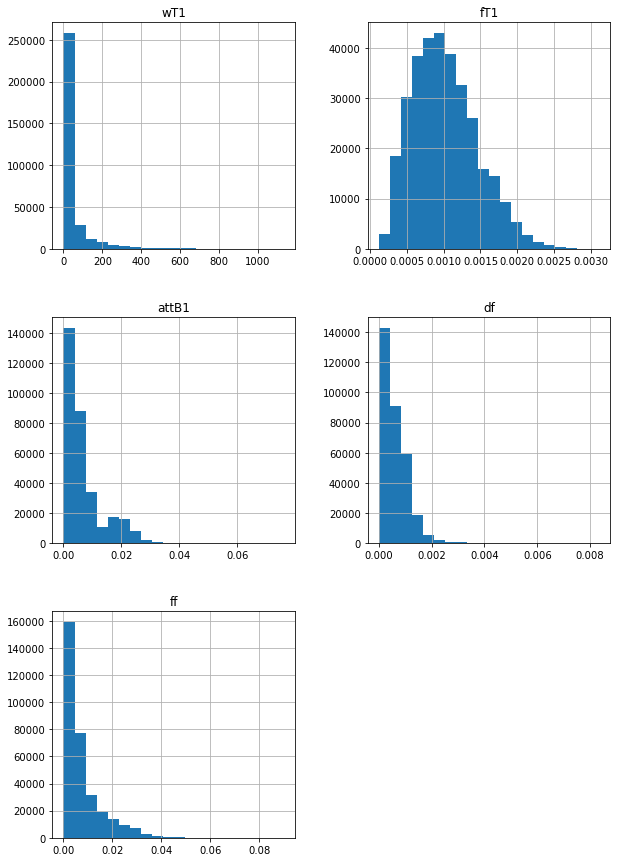

In [18]:
fig=plt.figure(figsize=(10,15));
ax = fig.gca()
df_errors.hist(bins=20,ax=ax);

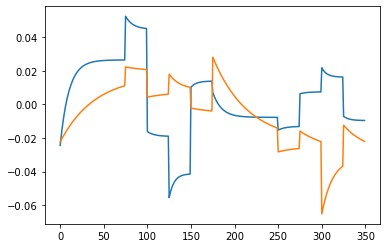

In [62]:
plt.plot(X_TF[k])
plt.plot(X_TF[j])

In [ ]:
#for j in range(Y_TF.shape[1]):
#    plt.figure()
#    plt.plot(predictions[10:,j])
#    plt.axhline(y=Y_TF[i,j],c="r",linestyle="dashed")
#

In [19]:
#volumes=volumes/np.linalg.norm(volumes,axis=0)
all_maps_adj=NN_search.search_patterns(dictfile,volumes)



(16384, 350)


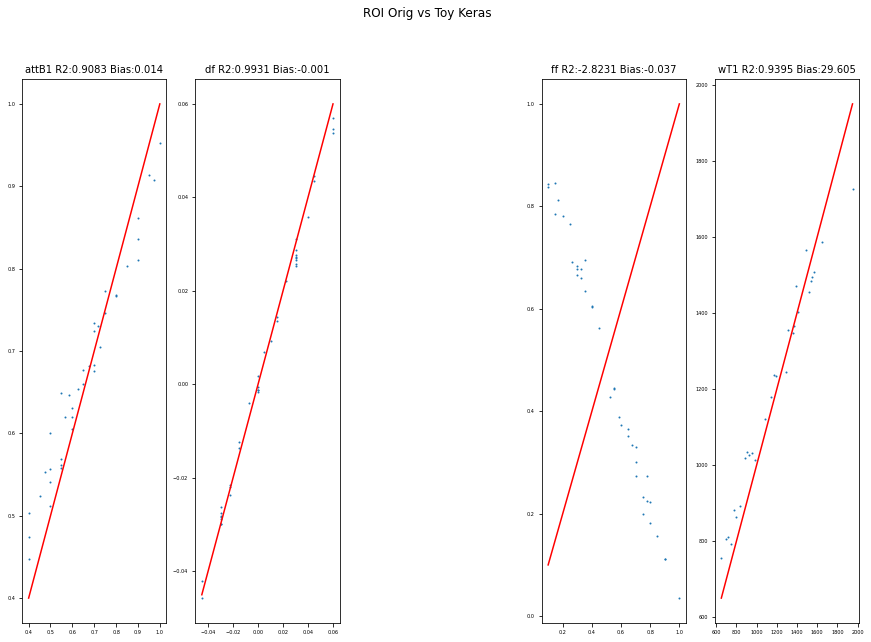

In [20]:

maskROI=buildROImask(m.paramMap)
regression_paramMaps_ROI(m.paramMap, all_maps_adj[0][0], m.mask > 0, all_maps_adj[0][1] > 0,maskROI=maskROI,
                             title="ROI Orig vs Toy Keras", proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7)


In [21]:
256-64

192

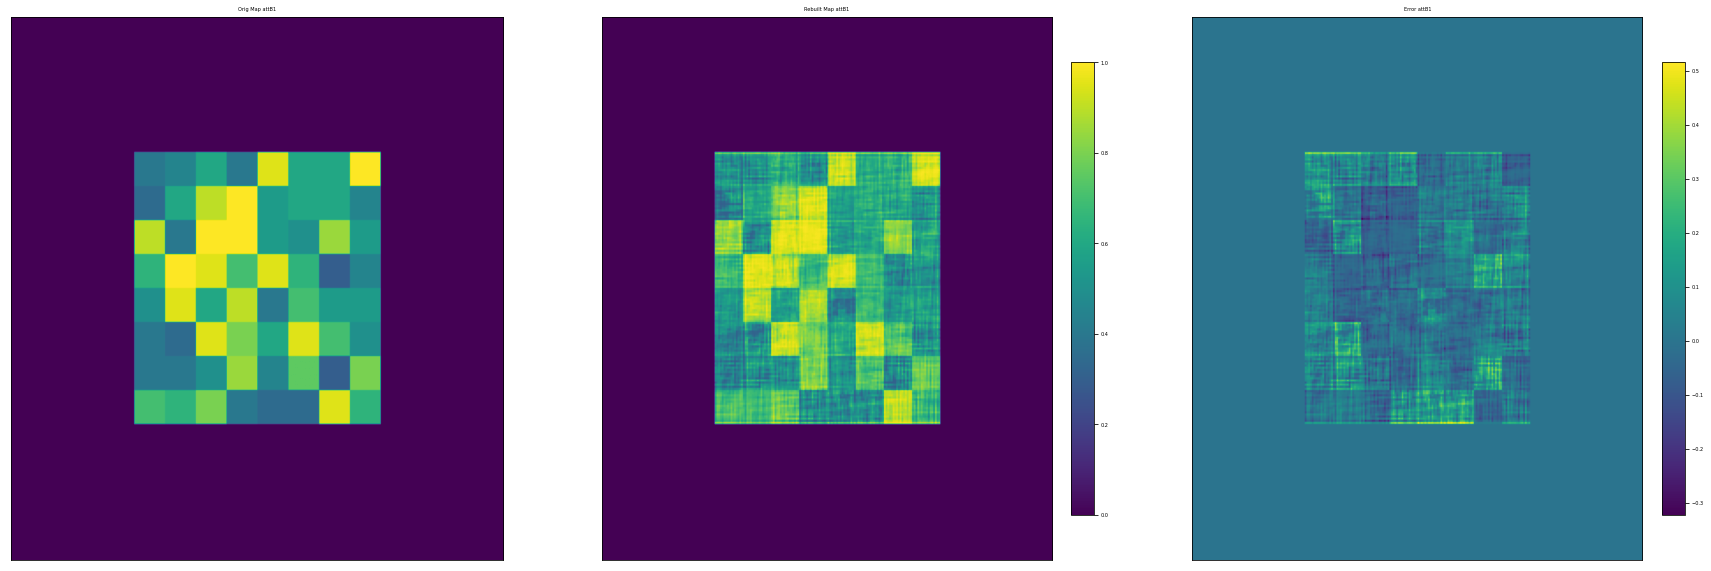

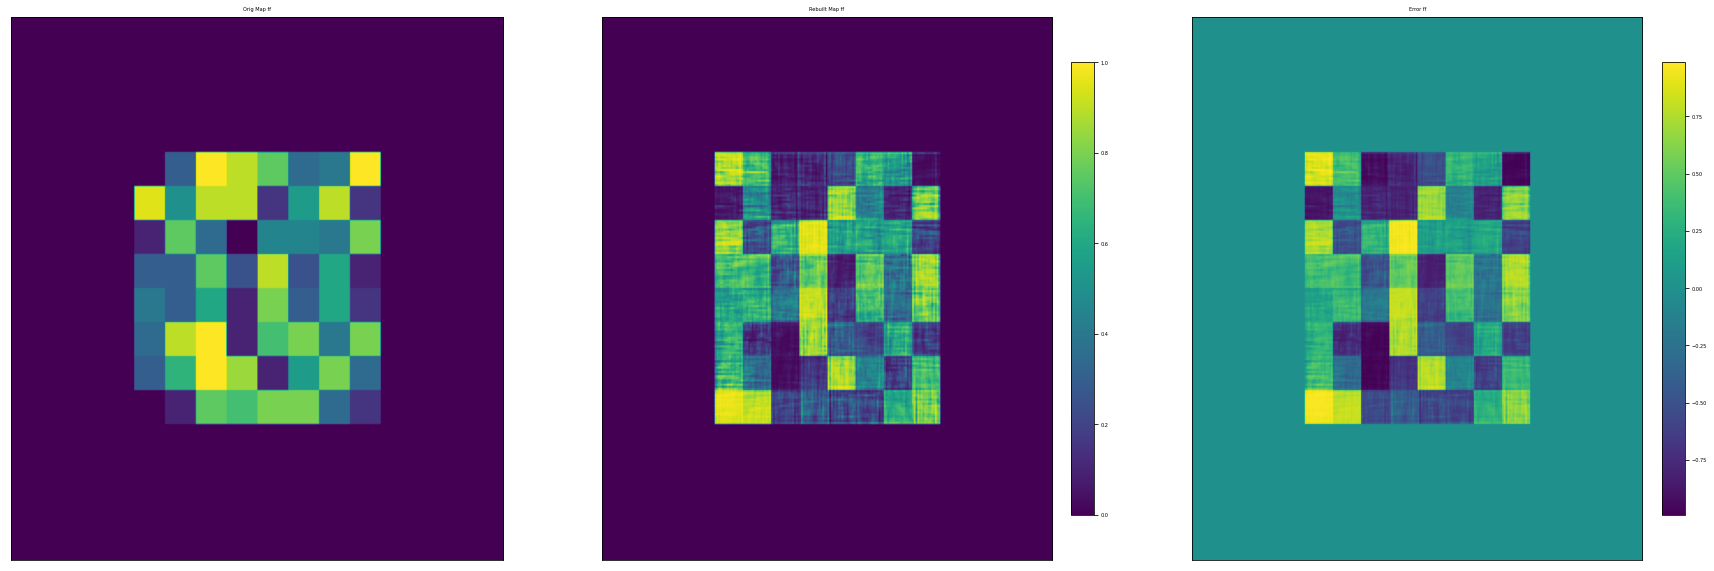

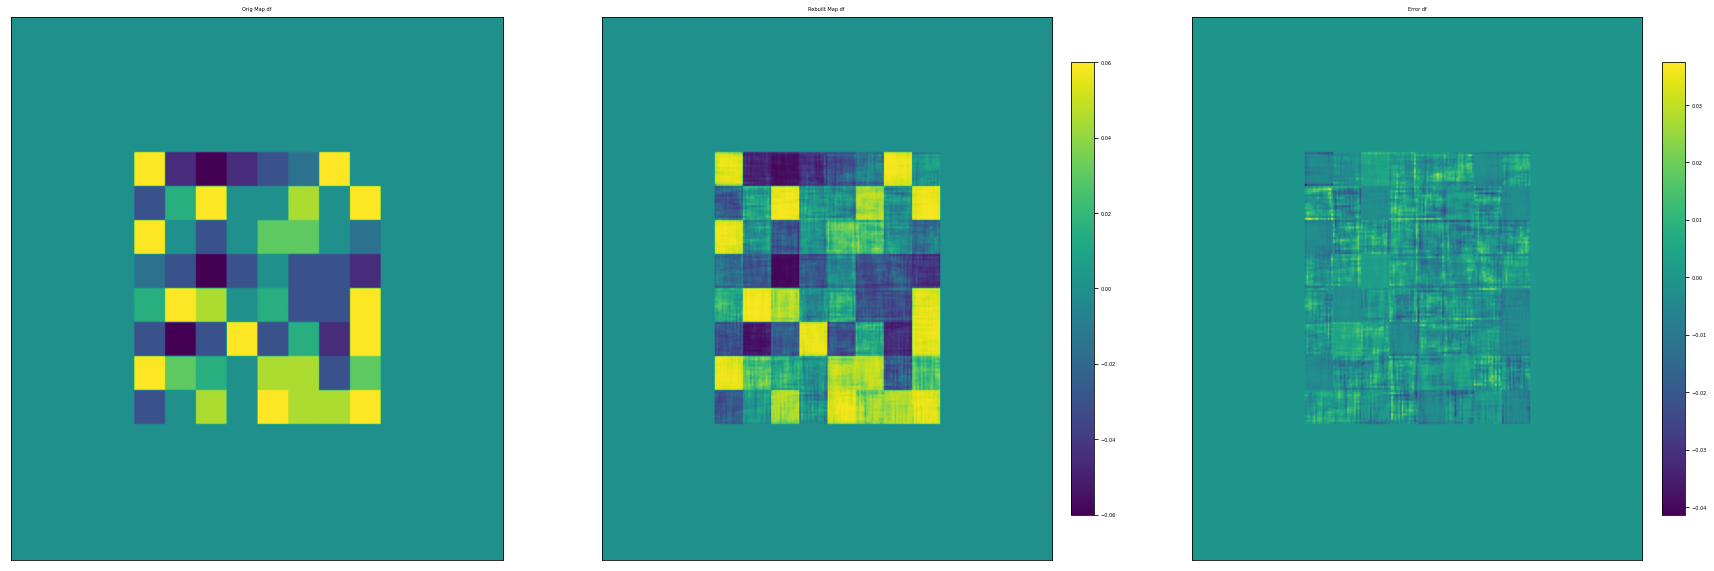

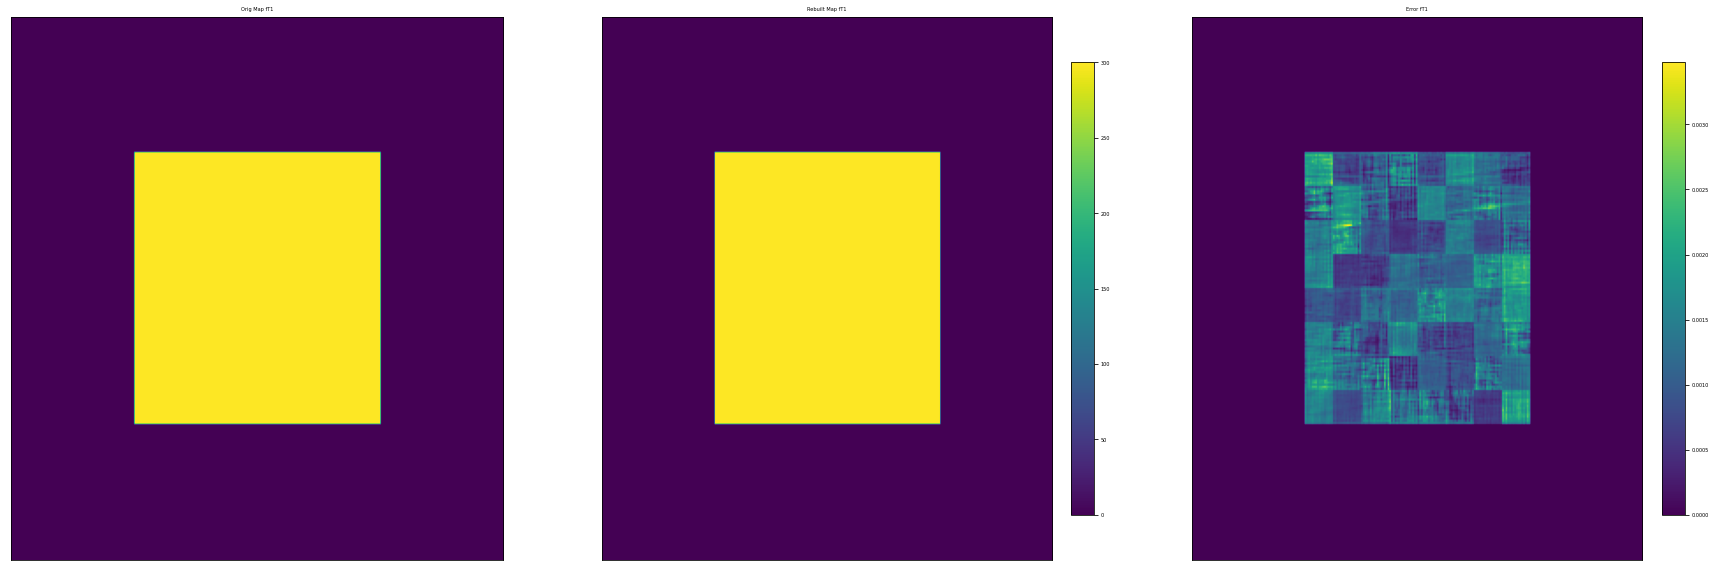

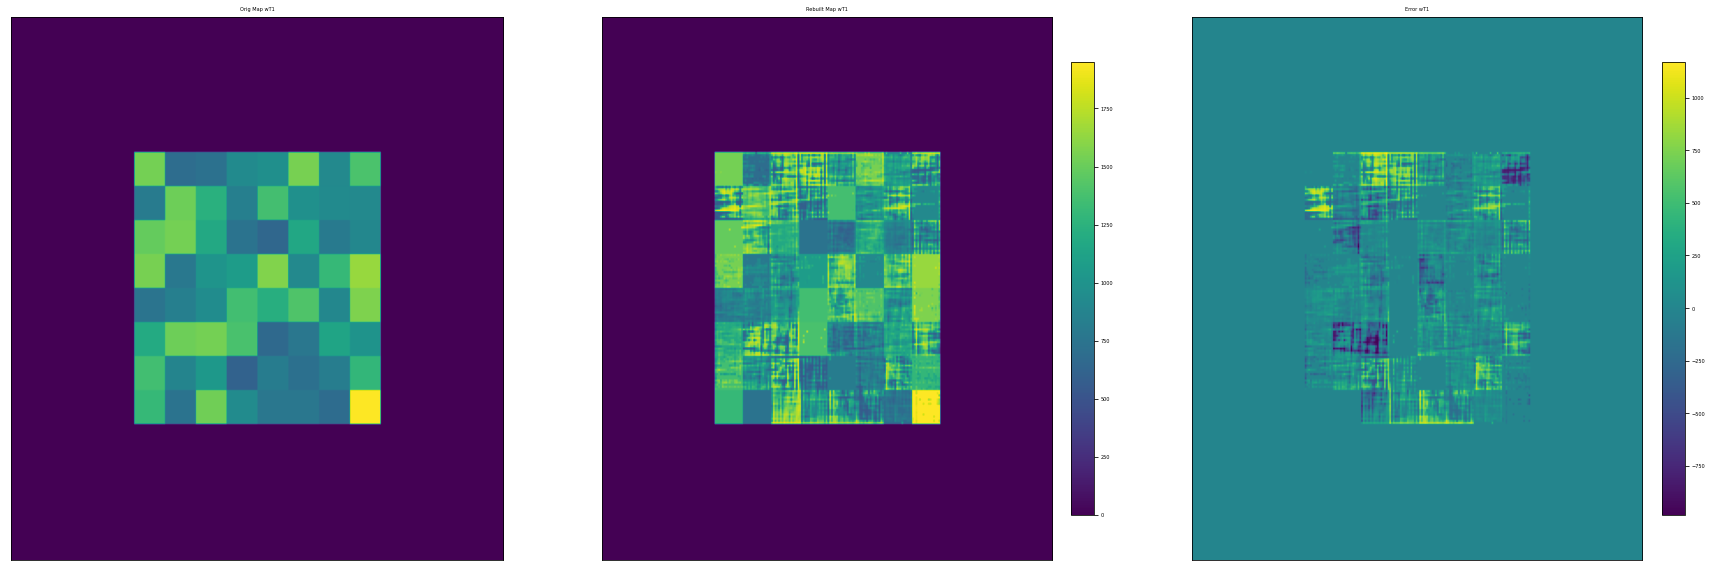

In [23]:

compare_paramMaps(m.paramMap, all_maps_adj[0][0], m.mask > 0, all_maps_adj[0][1] > 0,adj_wT1=True,fat_threshold=0.7,proj_on_mask1=True)

In [26]:
pixel=(70,70)
current_params={}

In [27]:
for k in m.paramMap.keys():
    if k not in ["wT2","fT2"]:
        current_params[k]=makevol(m.paramMap[k],m.mask>0)[pixel[0],pixel[1]]
    
print(current_params)

{'wT1': 1540.0, 'fT1': 300.0, 'attB1': 0.4, 'df': 0.06, 'ff': 0.0}


In [28]:
current_params_array=np.expand_dims(np.array(list(current_params.values())),axis=0)

In [29]:
closest_index=np.argmin(np.linalg.norm((Y_TF-current_params_array),axis=-1))

In [30]:
signal=volumes[:,pixel[0],pixel[1]]
real_signal=signal.real.T
imag_signal=signal.imag.T
real_signal=real_signal/np.linalg.norm(real_signal)
imag_signal=imag_signal/np.linalg.norm(imag_signal)

signal = np.concatenate((real_signal, imag_signal), axis=-1)
#signal=signal/np.linalg.norm(signal)
if NN_search.paramDict["input_scaler"] is not None:
    signal=NN_search.paramDict["input_scaler"].transform(signal.reshape(1,-1))
else:
    signal=signal.reshape(1,-1)
    
retrieved_params=NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(signal))
print(retrieved_params)

[[1.5088459e+03 3.0000171e+02 3.8097227e-01 5.6816854e-02 9.5832610e-01]]


In [31]:
current_params_retrieved_array=np.expand_dims(retrieved_params[0],axis=0)
closest_index_retrieved=np.argmin(np.linalg.norm((Y_TF-current_params_retrieved_array),axis=-1))

In [32]:
j=closest_index
print(Y_TF[j])
if NN_search.paramDict["input_scaler"] is not None:
    x=NN_search.paramDict["input_scaler"].transform(X_TF[j].reshape(1,-1))
else:
    x=X_TF[j].reshape(1,-1)
    
    NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(x))

[1.54e+03 3.00e+02 4.00e-01 6.00e-02 0.00e+00]


In [33]:
k=closest_index_retrieved
print(Y_TF[k])
if NN_search.paramDict["input_scaler"] is not None:
    x_retrieved=NN_search.paramDict["input_scaler"].transform(X_TF[k].reshape(1,-1))
else:
    x_retrieved=X_TF[k].reshape(1,-1)
    
    NN_search.paramDict["output_scaler"].inverse_transform(NN_search.paramDict["model"].predict(x_retrieved))

[1.51e+03 3.00e+02 4.00e-01 6.00e-02 9.50e-01]


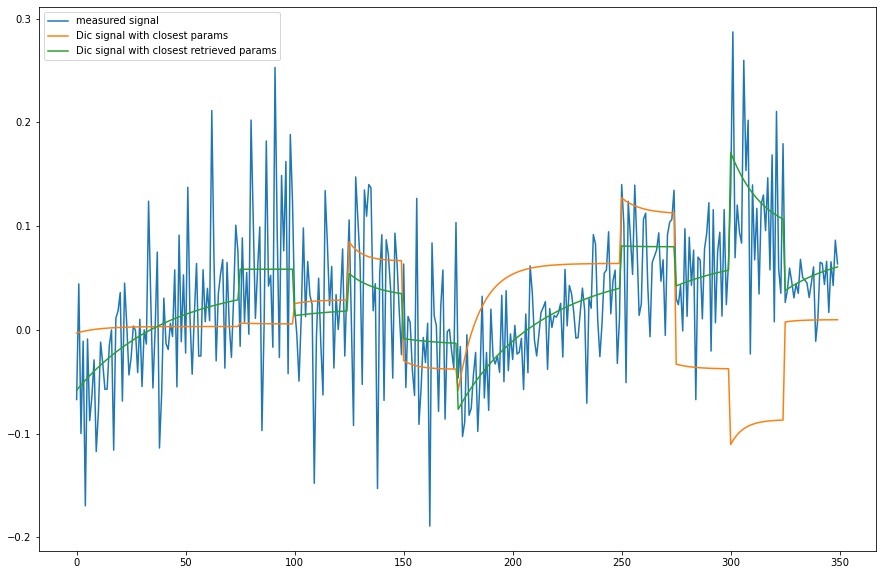

In [34]:
plt.figure(figsize=(15,10))
plt.plot(signal.T,label="measured signal")
plt.plot(x.T,label="Dic signal with closest params")
plt.plot(x_retrieved.T,label="Dic signal with closest retrieved params")
plt.legend()

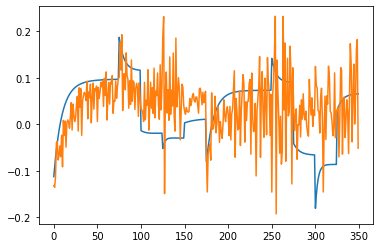

In [27]:
plt.plot(X_TF[j].reshape(1,-1).T)
plt.plot(np.concatenate((real_signal, imag_signal), axis=-1))

In [1]:
X_TF[j].reshape(1,-1)

NameError: name 'X_TF' is not defined

In [ ]:
NN_search.paramDict["input_scaler"].__dict__